<a href="https://colab.research.google.com/github/Abdallah-M-Ali/Machine-Learning-with-Python-Projects/blob/main/Predict_health_costs_with_regression2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [20]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [21]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-05-15 12:17:29--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0s      

2022-05-15 12:17:29 (125 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [22]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [23]:
dataset['sex'] = dataset['sex'].map({'male':0, 'female':1})
dataset['smoker'] = dataset['smoker'].map({'no':0, 'yes':1})
dataset

,age,sex,bmi,children,smoker,region,expenses
0,19,1,27.9,0,1,southwest,16884.92
1,18,0,33.8,1,0,southeast,1725.55
2,28,0,33.0,3,0,southeast,4449.46
3,33,0,22.7,0,0,northwest,21984.47
4,32,0,28.9,0,0,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,0,31.0,3,0,northwest,10600.55
1334,18,1,31.9,0,0,northeast,2205.98
1335,18,1,36.9,0,0,southeast,1629.83
1336,21,1,25.8,0,0,southwest,2007.95


In [24]:
dummies = pd.get_dummies(dataset['region'])
dummies

,northeast,northwest,southeast,southwest
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
1333,0,1,0,0
1334,1,0,0,0
1335,0,0,1,0
1336,0,0,0,1


In [25]:
merged = pd.concat([dataset, dummies], axis='columns')
merged

,age,sex,bmi,children,smoker,region,expenses,northeast,northwest,southeast,southwest
0,19,1,27.9,0,1,southwest,16884.92,0,0,0,1
1,18,0,33.8,1,0,southeast,1725.55,0,0,1,0
2,28,0,33.0,3,0,southeast,4449.46,0,0,1,0
3,33,0,22.7,0,0,northwest,21984.47,0,1,0,0
4,32,0,28.9,0,0,northwest,3866.86,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,0,31.0,3,0,northwest,10600.55,0,1,0,0
1334,18,1,31.9,0,0,northeast,2205.98,1,0,0,0
1335,18,1,36.9,0,0,southeast,1629.83,0,0,1,0
1336,21,1,25.8,0,0,southwest,2007.95,0,0,0,1


In [26]:
df = merged.drop(columns=(['region', 'southwest']))
df

,age,sex,bmi,children,smoker,expenses,northeast,northwest,southeast
0,19,1,27.9,0,1,16884.92,0,0,0
1,18,0,33.8,1,0,1725.55,0,0,1
2,28,0,33.0,3,0,4449.46,0,0,1
3,33,0,22.7,0,0,21984.47,0,1,0
4,32,0,28.9,0,0,3866.86,0,1,0
...,...,...,...,...,...,...,...,...,...
1333,50,0,31.0,3,0,10600.55,0,1,0
1334,18,1,31.9,0,0,2205.98,1,0,0
1335,18,1,36.9,0,0,1629.83,0,0,1
1336,21,1,25.8,0,0,2007.95,0,0,0


In [27]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [28]:
train_stats = train_dataset.describe().pop("expenses").transpose()
train_stats

count     1070.000000
mean     13056.551654
std      11994.260172
min       1121.870000
25%       4565.995000
50%       9289.085000
75%      15826.112500
max      60021.400000
Name: expenses, dtype: float64

In [29]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

In [30]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data

,age,sex,bmi,children,smoker,expenses,northeast,northwest,southeast
578,-1.084231,-1.088567,-1.086049,-1.088483,-1.088567,-0.277801,-1.088567,-1.088567,-1.088567
610,-1.084648,-1.088483,-1.086115,-1.088483,-1.088567,-0.375918,-1.088567,-1.088567,-1.088483
569,-1.084565,-1.088567,-1.085182,-1.088400,-1.088483,2.721758,-1.088567,-1.088483,-1.088567
1034,-1.083481,-1.088567,-1.085365,-1.088567,-1.088567,-0.008878,-1.088567,-1.088483,-1.088567
198,-1.084315,-1.088483,-1.087058,-1.088567,-1.088567,-0.284495,-1.088567,-1.088483,-1.088567
...,...,...,...,...,...,...,...,...,...
584,-1.086983,-1.088567,-1.086841,-1.088567,-1.088567,-0.984949,-1.088567,-1.088567,-1.088567
147,-1.084315,-1.088483,-1.085423,-1.088483,-1.088567,-0.265039,-1.088567,-1.088567,-1.088483
160,-1.085065,-1.088483,-1.086349,-1.088567,-1.088483,0.691344,-1.088567,-1.088483,-1.088567
750,-1.085482,-1.088483,-1.086366,-1.088567,-1.088483,0.540483,-1.088567,-1.088567,-1.088483


In [31]:
def build_model():
    model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(50, activation='relu'),
    layers.Dense(25, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
  ])
    
    
  #   model = keras.Sequential([
  #   layers.Dense(200, activation='relu', input_shape=[len(train_dataset.keys())]),
  #   layers.Dropout(0.1),
  #   layers.Dense(100, activation='relu'),

  #   layers.BatchNormalization(),
  #   layers.Dropout(0.1),
  #   layers.Dense(40, activation='relu'),

  #   layers.BatchNormalization(),
  #   layers.Dropout(0.1),
  #   layers.Dense(30, activation='relu'),

  #   layers.BatchNormalization(),
  #   layers.Dropout(0.1),
  #   layers.Dense(20, activation='relu'),

  #   layers.BatchNormalization(),
  #   layers.Dropout(0.1),
  #   layers.Dense(10, activation='relu'),

  #   layers.BatchNormalization(),
  #   layers.Dropout(0.1),
  #   layers.Dense(1)
  # ])

    optimizer = tf.keras.optimizers.RMSprop(0.1)
    # model.compile(
    # optimizer=tf.optimizers.Adam(learning_rate=0.1),
    # loss='mean_absolute_error',
    # metrics=['mae', 'mse'])
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [32]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               1000      
                                                                 
 dense_11 (Dense)            (None, 50)                5050      
                                                                 
 dense_12 (Dense)            (None, 25)                1275      
                                                                 
 dense_13 (Dense)            (None, 10)                260       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 7,596
Trainable params: 7,596
Non-trainable params: 0
_________________________________________________________________


In [33]:
model = build_model()

EPOCHS = 1000
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:122367568.0000,  mae:7218.3315,  mse:122367568.0000,  val_loss:18088878.0000,  val_mae:3807.8081,  val_mse:18088878.0000,  
....................................................................................................
Epoch: 100, loss:3665391.5000,  mae:1451.6763,  mse:3665391.5000,  val_loss:101578.7266,  val_mae:200.6904,  val_mse:101578.7266,  
....................................................................................................
Epoch: 200, loss:2594927.5000,  mae:950.1901,  mse:2594927.5000,  val_loss:2504.0105,  val_mae:18.8361,  val_mse:2504.0105,  
................................

In [34]:
hist = pd.DataFrame(early_history.history)
hist['epoch'] = early_history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
227,2528071.750,858.118042,2528071.750,3.162811e+06,1306.078003,3.162811e+06,227
228,1683161.625,785.375244,1683161.625,9.369544e+04,239.859634,9.369544e+04,228
229,2119659.250,873.531250,2119659.250,1.983376e+04,127.491447,1.983376e+04,229
230,2294825.500,872.646118,2294825.500,4.906756e+03,47.967197,4.906756e+03,230
231,1243913.750,576.802185,1243913.750,3.272044e+06,1424.934448,3.272044e+06,231


In [35]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [domain1_score]')

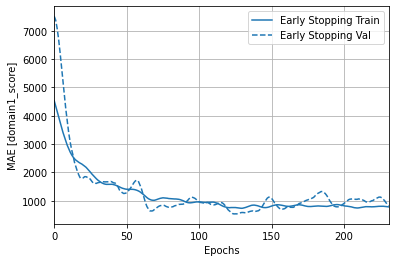

In [36]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylabel('MAE [domain1_score]')

Text(0, 0.5, 'MSE [domain1_score^2]')

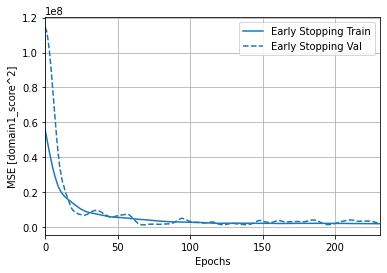

In [37]:
plotter.plot({'Early Stopping': early_history}, metric = "mse")
plt.ylabel('MSE [domain1_score^2]')

In [38]:
test_dataset = normed_test_data

9/9 - 0s - loss: 3220845.7500 - mae: 1403.7194 - mse: 3220845.7500 - 26ms/epoch - 3ms/step
Testing set Mean Abs Error: 1403.72 expenses
You passed the challenge. Great job!


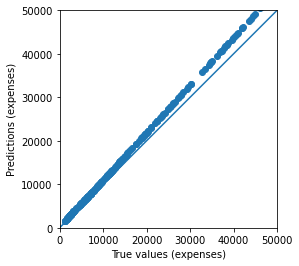

In [39]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
